<a href="https://colab.research.google.com/github/PosgradoMNA/Actividades-de-aprendizaje-Juan-sebastian-tellez-lopez/blob/main/TecMty_kmeans_target_Juan_Tellez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Actividad caso TARGET de la semana 7**

**Maestría en Inteligencia Artificial Aplicada**

**Curso: Ciencia y analítica de datos**

**Tecnológico de Monterrey**

**Prof Maria de la Paz Rico Fdz** 

**Nombre del estudiante: Juan Sebastián Téllez López**

**Matrícula: A01793859** 

**Fecha: Noviembre 5/2022**

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 2.2 MB/s 
     |████████████████████████████████| 1.0 MB 44.3 MB/s 
     |████████████████████████████████| 1.7 MB 40.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 46.7 MB/s 
     |████████████████████████████████| 6.3 MB 47.1 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27813 sha256=a3866c4d1237d99d40eb00c6d8b7d2aab27862b72ea0948acf965804b5ae7bba
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=a34a7a47239cc8918c64dc5f78d9708f4a3c4ec5f4894f86af03ea7f7986b1e8
  Stored in directory: /root/.

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [ ]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [ ]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [ ]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

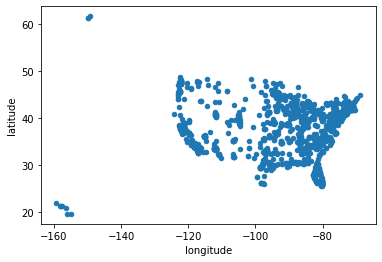

In [ ]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [ ]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [ ]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [ ]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [ ]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

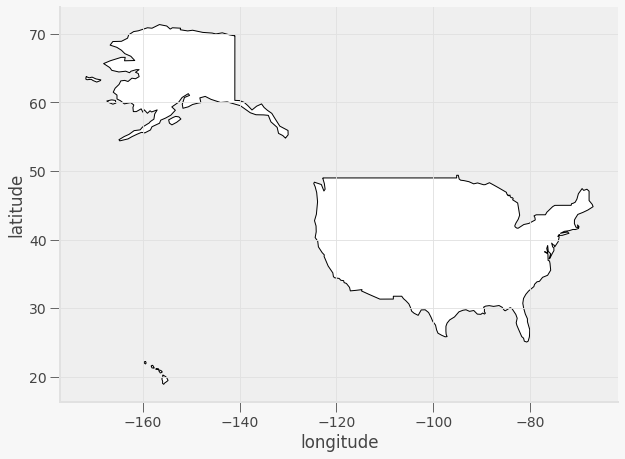

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

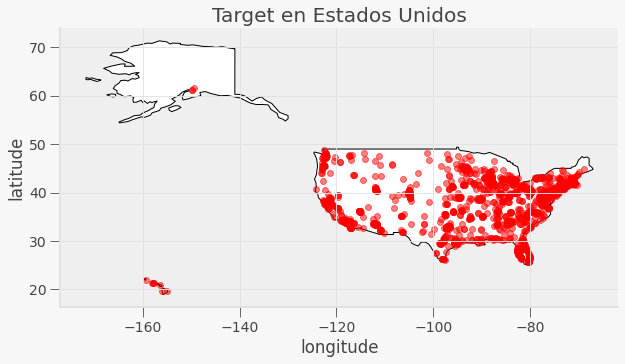

In [ ]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

## **Preguntas de la actividad:**



##**1. Encuentra las latitudes y longitudes de los almacenes**

In [ ]:
#almacenaremos en un Dataframe la latitud y longitud
X = df[["latitude","longitude"]]
X

,latitude,longitude
0,33.224225,-86.804174
1,33.334550,-86.989778
2,30.602875,-87.895932
3,34.560148,-86.971559
4,31.266061,-85.446422
...,...,...
1834,43.034293,-88.176840
1835,42.989604,-88.259806
1836,42.846799,-106.264166
1837,41.162019,-104.800048


####**1.1 ¿que ciudad es?**

Las ciudades en el territorio de los Estados Unidos son:
* Virginia.
* California.
* Missouri.

####**1.2 ¿a cuantas tiendas va surtir?**

De acuerdo a los hallazgos:

* Almacen 1: Surte a 826 tiendas.
* Almacen 2: Surte a 628 tiendas.
* Almacen 3: surte a 385 tiendas.

####**1.3 ¿A que distancia estarán?**

De la tienda 1 a la tienda 2 tenemos 2179.65 Millas de diferencia, mientras que de la tienda 2 a la tienda 3 tenemos 805.92

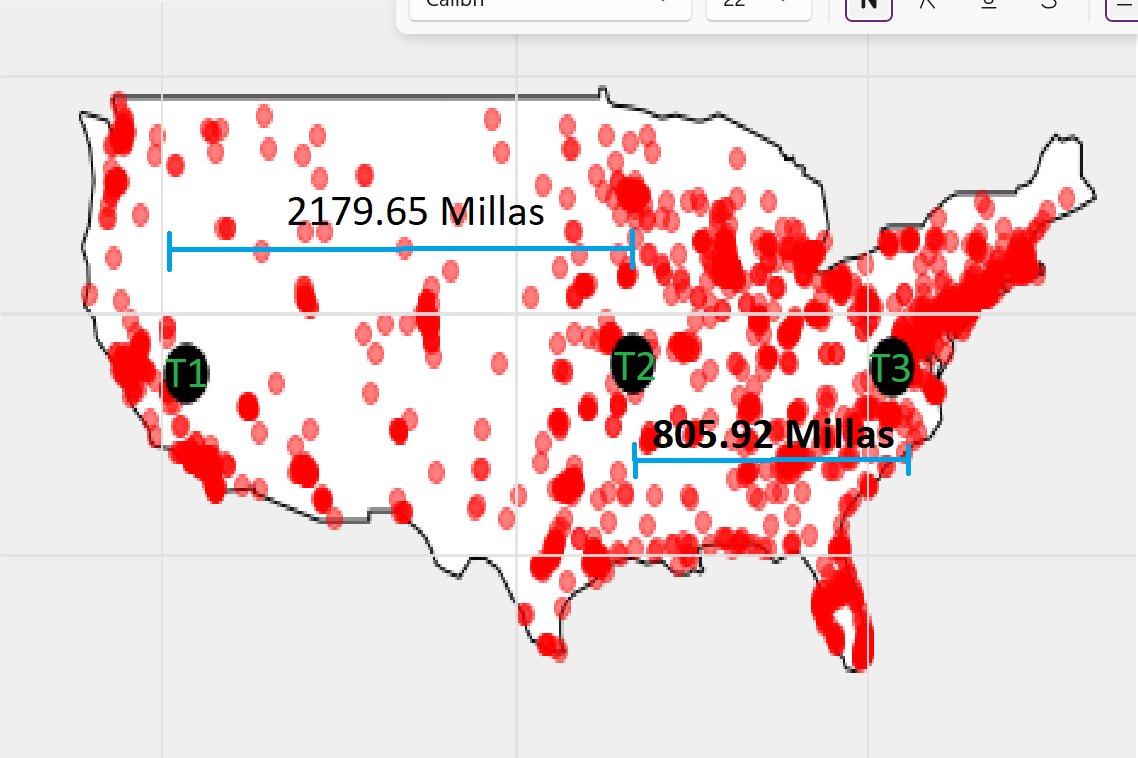

##**2. ¿Cómo elegiste el numero de almacenes?, justifica tu respuesta tecnicamente.**

De acuerdo a la bibliografia suministrada y leyendo un poco, encontre que existía algo llamado el metodo de codo, el cual permite mediante diferentes valores de k, producir una función de costo, de acuerdo al incremento del valor k, podemos tener disminución en ciertas distorciones, pero así mismo si mejora la distorción promedio, mejorara nuestros resultados al momento de dividir nuestros datos, y también gracias a los metodos realizados a continuación, como la curva de codo podemos apoyarnos visualmente en el proceso. 

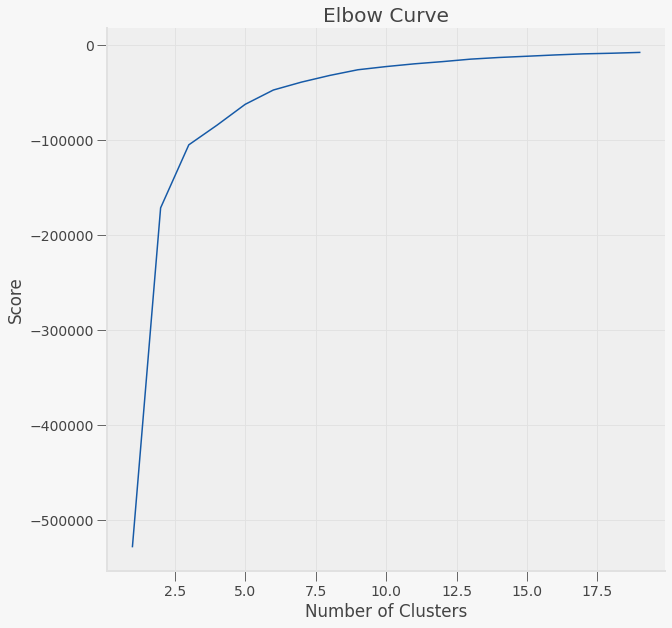

In [ ]:
#Para este paso importaremos la libreria de sklearn cluster para trabajar con kmeans
from sklearn.cluster import KMeans
X = df[["longitude","latitude"]]

#De esta manera definiremos nuestra elbow curve para determinar la cantidad optima de clusters que vamos a requerir.
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.subplots(figsize=(10,10))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [ ]:
#Ahora vamos a poder elegir los 3 clusters que nos daran las coordenadas para las tiendas que decidiremos poner
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X)
C = kmeans.cluster_centers_

C_DF = pd.DataFrame(C)
C_DF["Coordinates"] = list(zip(C_DF[0], C_DF[1]))
C_DF["Coordinates"] = C_DF["Coordinates"].apply(Point)


gdf_C = gpd.GeoDataFrame(C_DF, geometry="Coordinates")
gdf_C

,0,1,Coordinates
0,-78.569908,37.789554,POINT (-78.56991 37.78955)
1,-118.624473,37.487342,POINT (-118.62447 37.48734)
2,-93.327172,37.980063,POINT (-93.32717 37.98006)


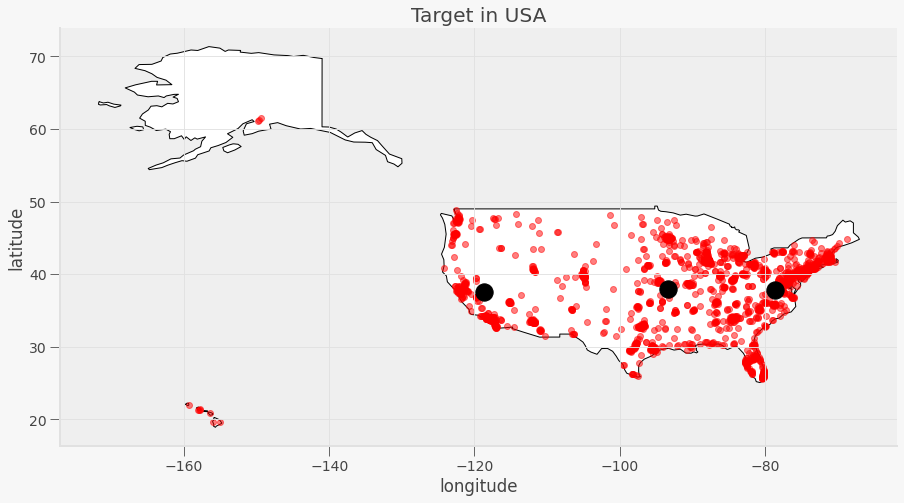

In [ ]:
#Vamos a graficar en el mapa de estados unidos unicamente.
fig, gax = plt.subplots(figsize=(15,10))
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

#Las ubicaciones actuales de las tiendas seran en rojo, mientras que las que pondremos estarán en negro
gdf.plot(ax=gax, color='red', alpha = 0.5)
gdf_C.plot(ax=gax, color='black', alpha = 1, markersize = 300)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target in USA')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [ ]:
#Realizaremos el conteo de tiendas por cluster
latlong['kmeans'] = kmeans.labels_
latlong.loc[:, 'kmeans'].value_counts()

In [ ]:
#Si recordamos las coordenadas que obtuvimos arriba, vamos a determinar en donde se encuentran exactamente, para lo cual es importante realizar una concatenación de la latitud y longitud.
from pandas.core.internals.concat import concat_arrays

print(gdf_C[0][0])
print(gdf_C[1][0])

Location1 = str(gdf_C[1][0]) + ", " + str(gdf_C[0][0])
print(Location1)
Location2 = str(gdf_C[1][1]) + ", " + str(gdf_C[0][1])
print(Location2)
Location3 = str(gdf_C[1][2]) + ", " + str(gdf_C[0][2])
print(Location3)

In [ ]:
#posteriormente, mediante la libreria geopy podemos tomar estos datos concatenados y apartir de su ubicación determinar la distancia a la que se encuentra cada uno. 
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="my-application")
Locations = [Location1, Location2, Location3]
for i in Locations:
  location = geolocator.reverse(i)

  print(location.address)

locations1 = geolocator.reverse(Location1)
locations2 = geolocator.reverse(Location2)

distancia1 = str(geodesic(Location1, Location2).miles)
print("\nDistancia entre el primer y segundo almacén : ", distancia1, " Millas \n")
distancia2 = str(geodesic(Location2, Location3).miles)
print("Distancia entre el segundo y tercer almacén : ", distancia2, " Millas \n")


##**3. Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, despues nos auxiliamos de una librería de datos geograficos.**



###**3.1 ¿qué librerías nos pueden ayudar a graficar este tipo de datos?**


Realmente en esta practica pude conocer estas dos librerias utilizadas y me sorprendío el potencial que tienen y estoy seguro que aun falta más por decubrir de ellas antes de utilizar otra, ya que actualmente en mi trabajo cuando tengo que realizar algún analisis geografico, me apoyo de las herramientas de Power BI para hacerlo. 

##**3.2 ¿Consideras importante que se grafique en un mapa?, ¿por qué?**


Siempre deberíamos considerar en primera instancia graficar tanto como podamos, ya que tenemos que pensar que nuestros analisis finalmente estarán en manos de personas que posiblemente no dominen del todo las habilidades de codigo, lo cual hace importante, poder entregarles información visualmente comprensible, y para el caso de esta practica, desde el contexto del problema podíamos determinar que el camino correcto para irnos sería mediante el analisis de coordenadas y que mejor forma para representarlo que un mapa.

##**4. Agrega las conclusiones**

De la siguiente practica aprendí lo siguiente: 

* Este ejemplo aterrizado a una situación de la vida real, aunque sea para Estados Unidos, me permitío adquirir herramientas para intentar hacer lo mismo con alguna empresa de mi pais, debido que los conocimientos adquiridos tanto como en las librerias para graficar, así como en la manera de encontrar puntos geograficos, abre un mundo de poisibilidades.
* Respecto a la tematica de los k-means, es muy valioso entender su concepto de agrupar datos permite profundizar en su uso durante la vida cotidiana, ademas que observando lo que buscan las compañias para contrar un cientifico o analista de datos, es muy mencionado como habilidad que brinda un plus. 